In [185]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import random_split
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import torchvision.datasets as datasets
import numpy as np
import matplotlib.pyplot as plt
import torch.optim as optim
from tqdm import tqdm
import seaborn
import pandas as pd

In [186]:
train_transforms = transforms.Compose([
    #transforms.Resize(32),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    #transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [187]:
test_transforms = transforms.Compose([
    transforms.ToTensor(),
    #transforms.Resize(32),
    #transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [188]:
train_dataset = datasets.ImageFolder(root='train', transform=train_transforms)
test_dataset = datasets.ImageFolder(root='validation', transform=test_transforms)

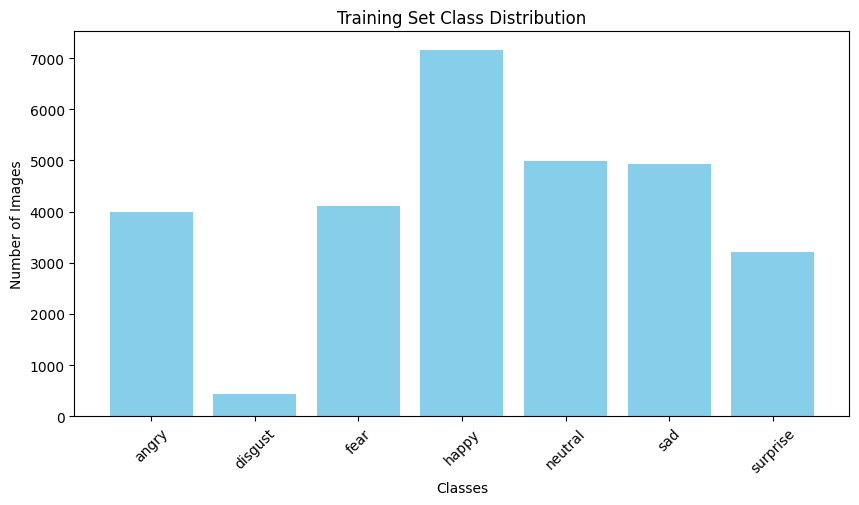

Class counts: {'angry': 3993, 'disgust': 436, 'fear': 4103, 'happy': 7164, 'neutral': 4982, 'sad': 4938, 'surprise': 3205}


In [189]:
import os 

def count_images_per_class(dataset_path):
    class_counts = {}
    for class_name in os.listdir(dataset_path):
        class_path = os.path.join(dataset_path, class_name)
        if os.path.isdir(class_path):
            class_counts[class_name] = len(os.listdir(class_path))
    return class_counts

train_class_counts = count_images_per_class('train')

def plot_class_distribution(class_counts, title):
    classes = list(class_counts.keys())
    counts = list(class_counts.values())
    
    plt.figure(figsize=(10, 5))
    plt.bar(classes, counts, color='skyblue')
    plt.xlabel('Classes')
    plt.ylabel('Number of Images')
    plt.title(title)
    plt.xticks(rotation=45)
    plt.show()

plot_class_distribution(train_class_counts, 'Training Set Class Distribution')
print("Class counts:", train_class_counts)


In [190]:
class_names = train_dataset.classes
class_names

['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']

In [191]:
img,labels = train_dataset[5]
input_shape = img.shape[-1]
num_classes = len(train_dataset.classes)
(input_shape,num_classes)


(48, 7)

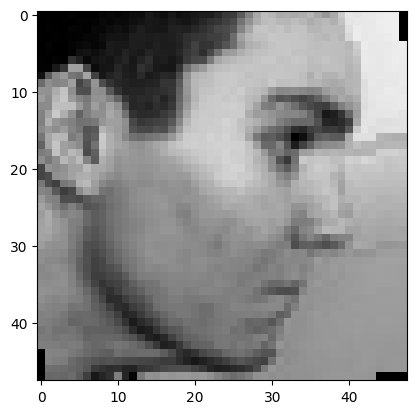

In [192]:
plt.imshow(np.transpose(img, (1, 2, 0)))
plt.show()

In [193]:
train_loader = DataLoader(train_dataset, batch_size=512, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=128)


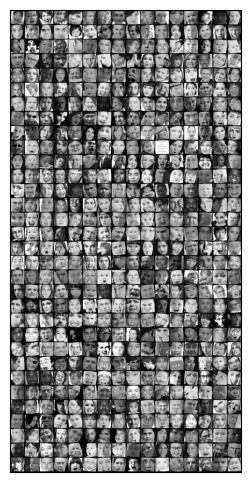

In [194]:
from torchvision.utils import make_grid

def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 6))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images, nrow=16).permute(1, 2, 0))
        break
show_batch(train_loader)

In [195]:
num_epochs = 40
lr = 0.0001

In [196]:
def conv_block(in_channels,out_channels,stride=1,pool=False):
    layers = [
        nn.Conv2d(in_channels,out_channels,kernel_size=3,padding=1,stride=stride,bias=False),
        nn.BatchNorm2d(out_channels),
        nn.LeakyReLU(negative_slope=0.01, inplace=True),
    ]
    if pool:
        layers.append (nn.AvgPool2d(2))
    return nn.Sequential(*layers)

In [197]:
class ResNet(nn.Module):
    def __init__(self, in_channels, num_classes):
        super().__init__()
        
        # Initial convolution
        self.conv1 = conv_block(in_channels, 64, stride=2)  # 64 x 24 x 24
        
        # First stack
        self.conv2 = conv_block(64, 64)  # 64 x 24 x 24
        self.res1 = nn.Sequential(
            conv_block(64, 64),
            conv_block(64, 64)
        )
        
        # Second stack
        self.conv3 = conv_block(64, 128, stride=2)  # 128 x 12 x 12
        self.res2 = nn.Sequential(
            conv_block(128, 128),
            conv_block(128, 128)
        )
        
        # Third stack
        self.conv4 = conv_block(128, 256, stride=2)  # 256 x 6 x 6
        self.res3 = nn.Sequential(
            conv_block(256, 256),
            conv_block(256, 256)
        )
        
        # Fourth stack
        self.conv5 = conv_block(256, 512, stride=2)  # 512 x 3 x 3
        self.res4 = nn.Sequential(
            conv_block(512, 512),
            conv_block(512, 512)
        )
        
        # Classifier
        self.classifier = nn.Sequential(
            nn.AdaptiveAvgPool2d((1, 1)),  # 512 x 1 x 1
            nn.Flatten(),  # 512
            nn.Dropout(0.5),
            nn.Linear(512, 256),  # 256
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(256, num_classes)  # num_classes
        )
        
    def forward(self, x):
        x = self.conv1(x)
        
        x = self.conv2(x)
        x = self.res1(x) + x
        
        x = self.conv3(x)
        x = self.res2(x) + x
        
        x = self.conv4(x)
        x = self.res3(x) + x
        
        x = self.conv5(x)
        x = self.res4(x) + x
        
        x = self.classifier(x)
        
        return x

In [198]:
class AlexNet(nn.Module):
    def __init__(self, num_classes=7, img_size=48):
        super(AlexNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 192, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(256 * (img_size // 8) * (img_size // 8), 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

# Instantiate the model
model = AlexNet(num_classes=7, img_size=48)

In [199]:
class CNN(nn.Module):
    def __init__(self, num_classes, img_size):
        super(CNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.LeakyReLU(negative_slope=0.01, inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(p=0.25),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.LeakyReLU(negative_slope=0.01, inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(p=0.25),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.LeakyReLU(negative_slope=0.01, inplace=False),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(p=0.25)
        )
        self.classifier = nn.Sequential(
            nn.Linear(128 * (img_size // 8) * (img_size // 8), 256),
            nn.LeakyReLU(negative_slope=0.01, inplace=True),
            nn.Dropout(p=0.5),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x


In [200]:
device = torch.device('cuda')

In [201]:
model = ResNet(3,7).to(device)
model

ResNet(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01, inplace=True)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01, inplace=True)
  )
  (res1): Sequential(
    (0): Sequential(
      (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.01, inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats

In [202]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(),lr=lr)


In [203]:
import matplotlib.pyplot as plt

def train(train_loader, model, criterion, optimizer, num_epochs):
    train_losses = []
    train_accuracies = []
    
    for epoch in range(num_epochs):
        model.train()
        total_correct = 0
        total_samples = 0
        total_loss = 0.0
        train_loader = tqdm(train_loader, desc=f'Epoch {epoch + 1}/{num_epochs}', leave=False)

        for images, labels in train_loader:
            images = images.to(device)
            labels = labels.to(device)
            
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            _, predicted = torch.max(outputs, 1)
            total_correct += (predicted == labels).sum().item()
            total_samples += labels.size(0)
            total_loss += loss.item()
        
        epoch_loss = total_loss / len(train_loader)
        epoch_acc = total_correct / total_samples * 100
        
        train_losses.append(epoch_loss)
        train_accuracies.append(epoch_acc)
        
        if ((epoch+1)%5==0):
            print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {epoch_loss:.4f}, Train Accuracy: {epoch_acc:.2f}%')

    epochs = range(1, num_epochs + 1)
    
    plt.figure(figsize=(12, 4))
    
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, 'b', label='Training loss')
    plt.title('Training loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accuracies, 'r', label='Training accuracy')
    plt.title('Training accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy (%)')
    plt.legend()
    
    plt.show()



    
    
    
    
    

In [204]:
#Best option as of know was LR = 0.001, Adam, ResNet Arch

Epoch [5/40], Train Loss: 1.3161, Train Accuracy: 49.46%


Epoch [10/40], Train Loss: 1.0713, Train Accuracy: 59.98%


Epoch [15/40], Train Loss: 0.8605, Train Accuracy: 68.73%


Epoch [20/40], Train Loss: 0.6732, Train Accuracy: 76.21%


Epoch [25/40], Train Loss: 0.5128, Train Accuracy: 82.13%


Epoch [30/40], Train Loss: 0.3959, Train Accuracy: 86.82%


Epoch [35/40], Train Loss: 0.3051, Train Accuracy: 89.87%


Epoch [40/40], Train Loss: 0.2368, Train Accuracy: 92.13%


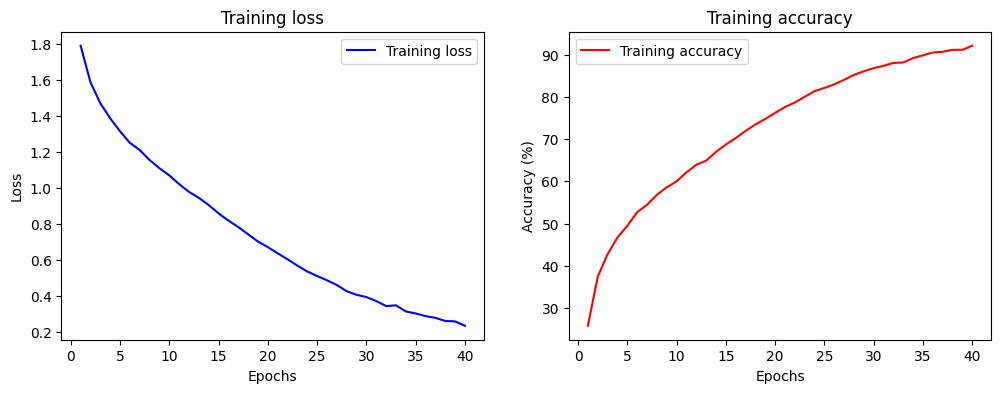

In [205]:
train(train_loader, model, criterion, optimizer, num_epochs)


In [206]:
torch.save(model.state_dict(), 'expression_classifer.pth')


Accuracy: 0.92


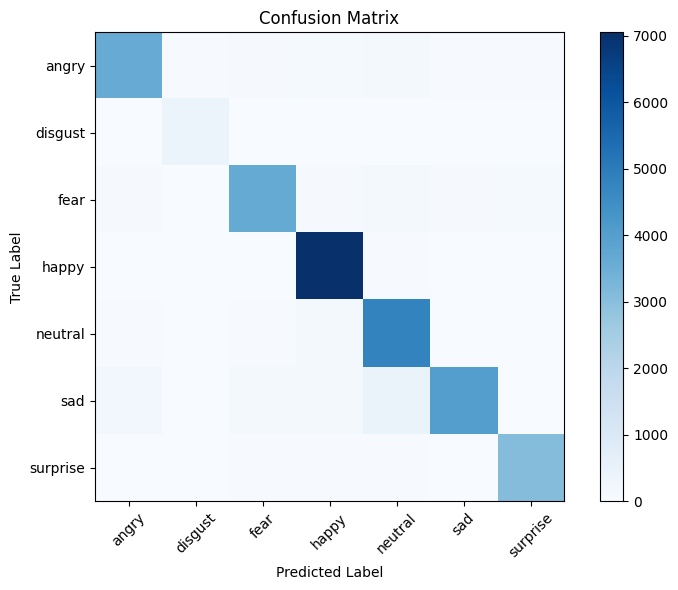

              precision    recall  f1-score   support

       angry       0.93      0.90      0.91      3993
     disgust       0.86      0.97      0.91       436
        fear       0.92      0.89      0.90      4103
       happy       0.94      0.98      0.96      7164
     neutral       0.85      0.96      0.90      4982
         sad       0.96      0.81      0.88      4938
    surprise       0.95      0.95      0.95      3205

    accuracy                           0.92     28821
   macro avg       0.92      0.92      0.92     28821
weighted avg       0.92      0.92      0.92     28821



In [207]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

model.eval()
predictions = []
true_labels = []

with torch.no_grad():
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        predictions.extend(predicted.cpu().numpy())
        true_labels.extend(labels.cpu().numpy())

predictions = np.array(predictions)
true_labels = np.array(true_labels)
accuracy = np.mean(predictions == true_labels)
print(f'Accuracy: {accuracy:.2f}')

class_names = train_dataset.classes
conf_matrix = confusion_matrix(true_labels, predictions)
plt.figure(figsize=(8, 6))
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names, rotation=45)
plt.yticks(tick_marks, class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()
plt.show()

print(classification_report(true_labels, predictions, target_names=class_names))

Testing Accuracy: 0.59


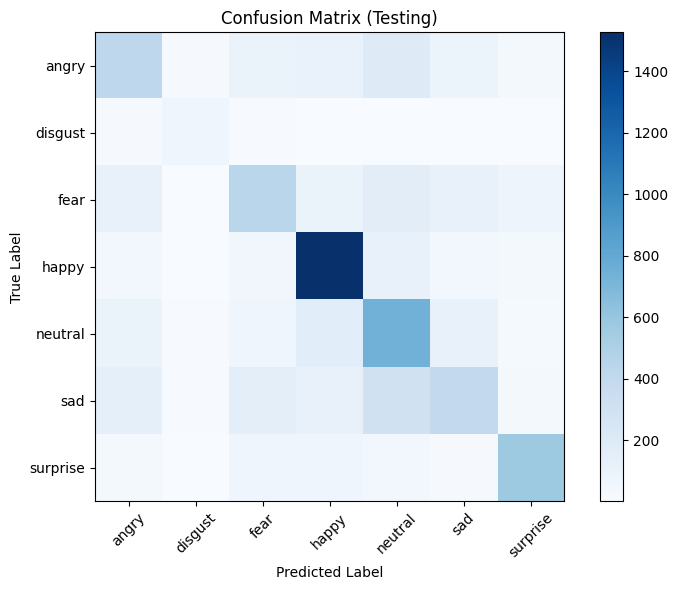

              precision    recall  f1-score   support

       angry       0.49      0.44      0.46       960
     disgust       0.56      0.59      0.57       111
        fear       0.50      0.43      0.46      1018
       happy       0.73      0.84      0.78      1825
     neutral       0.47      0.61      0.53      1216
         sad       0.51      0.35      0.41      1139
    surprise       0.74      0.71      0.72       797

    accuracy                           0.59      7066
   macro avg       0.57      0.57      0.56      7066
weighted avg       0.58      0.59      0.58      7066



In [208]:

model.eval()
predictions = []
true_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        predictions.extend(predicted.cpu().numpy())
        true_labels.extend(labels.cpu().numpy())

predictions = np.array(predictions)
true_labels = np.array(true_labels)
accuracy = np.mean(predictions == true_labels)
print(f'Testing Accuracy: {accuracy:.2f}')

conf_matrix = confusion_matrix(true_labels, predictions)
plt.figure(figsize=(8, 6))
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix (Testing)')
plt.colorbar()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names, rotation=45)
plt.yticks(tick_marks, class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()
plt.show()

print(classification_report(true_labels, predictions, target_names=class_names))

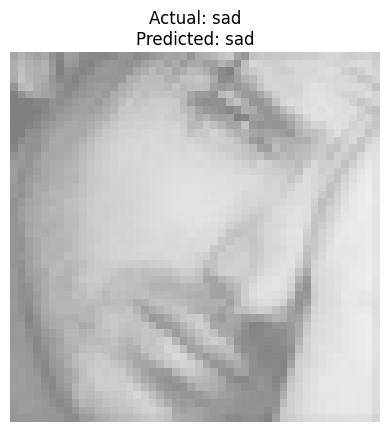

Image 5416:
Actual class: sad
Predicted class: sad
------------------------


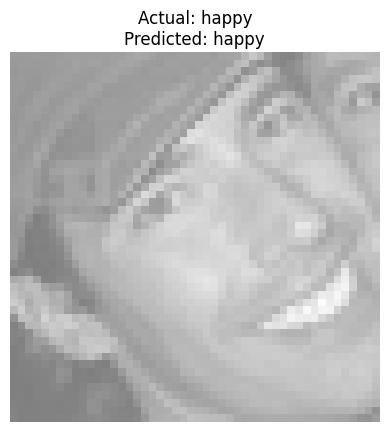

Image 3136:
Actual class: happy
Predicted class: happy
------------------------


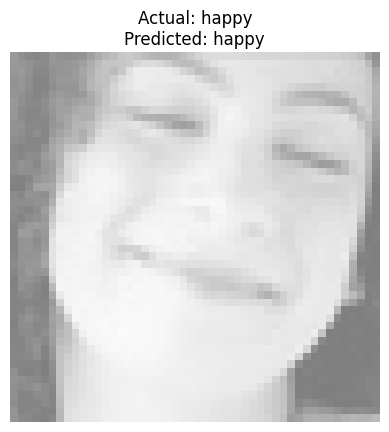

Image 2755:
Actual class: happy
Predicted class: happy
------------------------


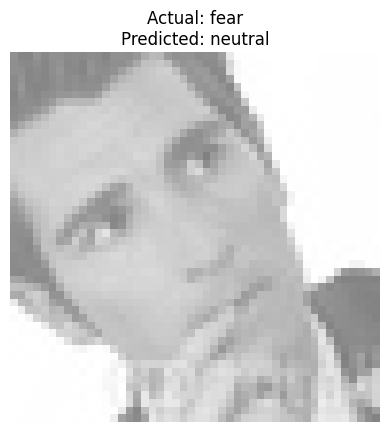

Image 1320:
Actual class: fear
Predicted class: neutral
------------------------


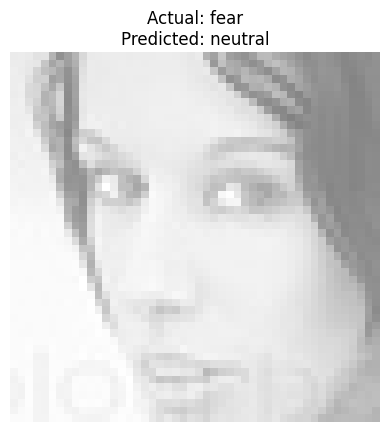

Image 1965:
Actual class: fear
Predicted class: neutral
------------------------


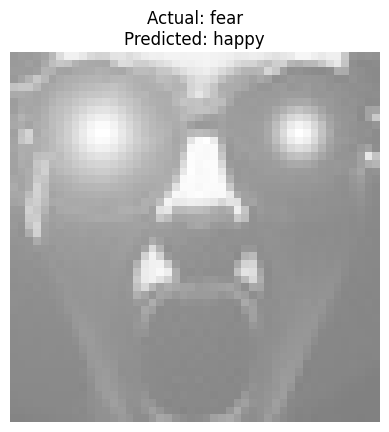

Image 1346:
Actual class: fear
Predicted class: happy
------------------------


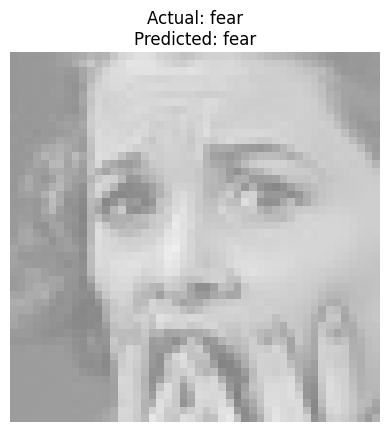

Image 1505:
Actual class: fear
Predicted class: fear
------------------------


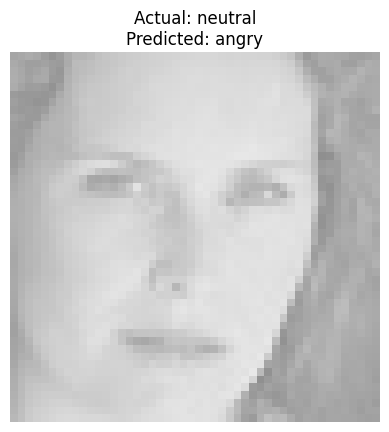

Image 3934:
Actual class: neutral
Predicted class: angry
------------------------


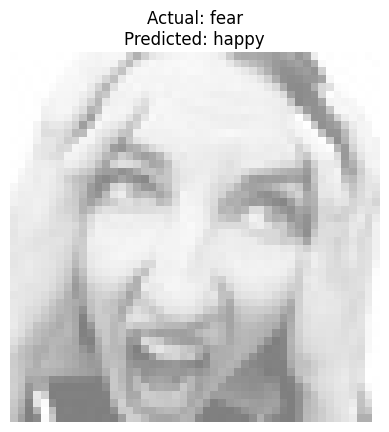

Image 1361:
Actual class: fear
Predicted class: happy
------------------------


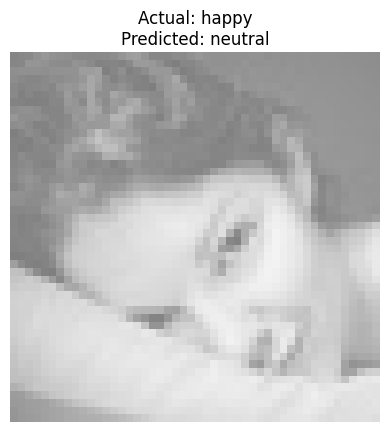

Image 2162:
Actual class: happy
Predicted class: neutral
------------------------


In [209]:
import torch
import matplotlib.pyplot as plt
import random
import numpy as np

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model.eval()



def imshow(img):
    img = img.cpu().numpy().transpose((1, 2, 0))
    mean = np.array([0.5, 0.5, 0.5])
    std = np.array([0.5, 0.5, 0.5])
    img = std * img + mean
    img = np.clip(img, 0, 1)
    plt.imshow(img)
    plt.axis('off')

total_images = len(test_loader.dataset)

random_indices = random.sample(range(total_images), 10)

for idx in random_indices:
    image, label = test_loader.dataset[idx]
    
    image = image.unsqueeze(0).to(device)
    label = torch.tensor(label).to(device)

    with torch.no_grad():
        output = model(image)
    
    _, predicted = torch.max(output, 1)

    plt.figure()
    imshow(image.squeeze(0).cpu())
    plt.title(f"Actual: {class_names[label.item()]}\nPredicted: {class_names[predicted.item()]}")
    plt.show()

    print(f"Image {idx}:")
    print(f"Actual class: {class_names[label.item()]}")
    print(f"Predicted class: {class_names[predicted.item()]}")
    print("------------------------")

In [210]:
from PIL import Image
import torch
import torchvision.transforms as transforms

def predict_image_class(image_path, model, class_names):
    image_path = "images/" + image_path
    entered_image = Image.open(image_path)

    
    transform = transforms.Compose([
        transforms.Resize((32, 32)),
        transforms.ToTensor(),
    ])

    transformed_image = transform(entered_image).unsqueeze(0)  

    
    model.eval()

    
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    transformed_image = transformed_image.to(device)

    
    with torch.no_grad():
        outputs = model(transformed_image)

    
    _, predicted = torch.max(outputs, 1)
    predicted_class = predicted.item()  

    
    probs = torch.softmax(outputs, dim=1)
    predicted_prob = probs[0, predicted_class].item()

    print(f'Predicted Class: {class_names[predicted_class]}, Probability: {predicted_prob:.2f}')
    
    plt.imshow(entered_image)
    plt.show()


In [211]:
num_classes

7